# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn, optim
from torchvision import datasets, models, transforms
from PIL import Image
from collections import OrderedDict

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# DONE: Define your transforms for the training, validation, and testing sets

#transform for the validation and test datasets
transforms_valid_test = transforms.Compose([
                                    transforms.Resize(255),
                                    transforms.CenterCrop(244),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406),
                                    (0.229, 0.224, 0.225))
                                    ])
#transform for training datasets
transforms_train = transforms.Compose([
                        transforms.Resize(255),
                        transforms.CenterCrop(244),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485,0.456,0.406),
                        (0.229, 0.224, 0.225))
                        ])

# DONE: Load the datasets with ImageFolder

#loading the images
image_datasets = datasets.ImageFolder(data_dir, 
                                    transform = transforms_valid_test)
#loading the training images
train_datasets = datasets.ImageFolder(train_dir, 
                                    transform = transforms_train)
#loading the validation images
valid_datasets = datasets.ImageFolder(valid_dir, 
                                    transform = transforms_valid_test)
#loading the test images
test_datasets = datasets.ImageFolder(test_dir, 
                                    transform = transforms_valid_test)
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders=torch.utils.data.DataLoader(image_datasets, batch_size=64,
                                        shuffle=True)
trainloaders=torch.utils.data.DataLoader(train_datasets, batch_size=64,
                                         shuffle=True)
validloaders=torch.utils.data.DataLoader(valid_datasets, batch_size=64,
                                         shuffle=True)
testloaders=torch.utils.data.DataLoader(test_datasets, batch_size=64,
                                        shuffle=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

<font color='red'>**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.</font>

In [5]:
# TODO: Build and train your network

# Initialize a pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Set all model parameters to not require gradient computation during training
for param in model.parameters():
    param.requires_grad = False
    

# Print the model object
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:07<00:00, 70251825.19it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
#creating a classifier

# Define a new classifier for the VGG16 model
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)), # fully connected layer with 25088 inputs and 4096 outputs
                          ('relu', nn.ReLU()), # activation function
                          ('fc2', nn.Linear(4096, 102)), # fully connected layer with 4096 inputs and 102 outputs
                          ('output', nn.LogSoftmax(dim=1)) # output layer with log-softmax activation
                          ]))

# Replace the original classifier with the new classifier
model.classifier = classifier

# Define the loss function as Negative Log Likelihood Loss
criterion = nn.NLLLoss()

# Define the optimizer as Adam, with a learning rate of 0.001, and only update the classifier's parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Print the model object
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [7]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# Loop over the number of desired training epochs
for epoch in range(epochs):
    for inputs, labels in trainloaders:
        steps += 1
        
        # Move input and label tensors to the default device (GPU if available, otherwise CPU)
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        logps = model.forward(inputs) # Forward pass
        loss = criterion(logps, labels) # Compute loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Accumulate loss for printing
        
        # Print statistics every 'print_every' steps
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            
            # Set model to evaluation mode
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloaders:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    # Accumulate test loss
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            # Print statistics for the current epoch        
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(validloaders):.3f}.. "
                  f"Test accuracy: {accuracy/len(validloaders):.3f}")
            # reset running loss
            running_loss = 0
            # set model back to train mode
            model.train()

Epoch 1/1.. Train loss: 13.680.. Test loss: 10.331.. Test accuracy: 0.090
Epoch 1/1.. Train loss: 7.311.. Test loss: 5.613.. Test accuracy: 0.210
Epoch 1/1.. Train loss: 4.561.. Test loss: 3.461.. Test accuracy: 0.299
Epoch 1/1.. Train loss: 2.895.. Test loss: 2.678.. Test accuracy: 0.400
Epoch 1/1.. Train loss: 2.452.. Test loss: 1.934.. Test accuracy: 0.549
Epoch 1/1.. Train loss: 1.755.. Test loss: 1.580.. Test accuracy: 0.594
Epoch 1/1.. Train loss: 1.429.. Test loss: 1.284.. Test accuracy: 0.664
Epoch 1/1.. Train loss: 1.220.. Test loss: 1.090.. Test accuracy: 0.731
Epoch 1/1.. Train loss: 0.973.. Test loss: 0.951.. Test accuracy: 0.764
Epoch 1/1.. Train loss: 1.025.. Test loss: 0.928.. Test accuracy: 0.756
Epoch 1/1.. Train loss: 0.864.. Test loss: 0.896.. Test accuracy: 0.764
Epoch 1/1.. Train loss: 0.824.. Test loss: 0.902.. Test accuracy: 0.783
Epoch 1/1.. Train loss: 0.783.. Test loss: 0.833.. Test accuracy: 0.795
Epoch 1/1.. Train loss: 0.718.. Test loss: 0.690.. Test accura

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:
# TODO: Do validation on the test set

correct,total = 0,0

# No gradient computation is needed in evaluation
with torch.no_grad():
    # Set the model to evaluation mode
    model.eval()
    for data in testloaders:
        images, labels = data
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # Forward pass
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # Find total number of images
        correct += (predicted == labels).sum().item() # Find number of correctly predicted images

# Print the final accuracy on test set        
print('Test Accuracy: %d%%' % (100 * correct / total))

Test Accuracy: 82%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [9]:
#Save the checkpoint 
model.class_to_idx = train_datasets.class_to_idx


# Create a dictionary to store all the important information of the model
checkpoint = {'transfer_model': 'vgg16',
              'input_size': 25088,
              'output_size': 102,
              'features': model.features,
              'classifier': model.classifier,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'idx_to_class': {v: k for k, v in train_datasets.class_to_idx.items()}
             }

# Save the checkpoint dictionary to a file named 'check.pth'
torch.save(checkpoint, 'check.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
#a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    model_info = torch.load(filepath) # Load the checkpoint file
    model = models.vgg16(pretrained=True) # Initialize a VGG16 model with pre-trained weights
    
    # Define a new classifier
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(25088, 4096)),
                              ('relu', nn.ReLU()),
                              ('fc2', nn.Linear(4096, 102)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    
    # Replace the original classifier with the new one
    model.classifier = classifier
    
    # Load the state dict saved in the checkpoint file
    model.load_state_dict(model_info['state_dict'])
    return model, model_info

# Load the checkpoint
model, model_info = load_checkpoint('check.pth')

# Print the model
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(image):
    '''Scales, crops, and normalizes a PIL image for a PyTorch model,
    returns a Numpy array'''

    # Open the image file
    im = Image.open(image)

    # Get the width and height of the image
    width, height = im.size
    aspect_ratio = width / height

    # Resize the image to 256 pixels on the shorter side
    if aspect_ratio > 1:
        im = im.resize((256, int(256 / aspect_ratio)))
    else:
        im = im.resize((int(256 * aspect_ratio), 256))

    # Crop the image to 244x244 pixels centered
    left = (im.width - 244) / 2
    top = (im.height - 244) / 2
    right = (im.width + 244) / 2
    bottom = (im.height + 244) / 2
    im = im.crop((left, top, right, bottom))

    # Convert the image to a numpy array
    np_image = np.array(im) / 255

    # Normalize the image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    # Transpose the image
    np_image = np_image.transpose((2, 0, 1))

    # Return the processed image
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [16]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # Transpose the image from (channel, height, width) to (height, width, channel)
    image = image.numpy().transpose((1, 2, 0))
    
    # Un-normalize the image by adding back the mean and scaling by the standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip the image values to between 0 and 1
    image = np.clip(image, 0, 1)
    
    # Show the image
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [17]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Open the image file and process it
    with torch.no_grad():
        image = process_image(image_path)
        # Convert the image to a tensor
        image = torch.from_numpy(image)
        # Add a batch dimension to the image
        image.unsqueeze_(0)
        # Convert the image to float type
        image = image.float()
        # Load the model from the checkpoint
        model, _ = load_checkpoint(model)
        # Get the output of the model
        outputs = model(image)
        # Get the top k classes and their probabilities
        probs, classes = torch.exp(outputs).topk(topk)
        # Convert the classes and probs to lists
        return probs[0].tolist(), classes[0].add(1).tolist()
    
# Example call to the function
predict('flowers/train/1/image_06734.jpg','check.pth')

([0.9869911670684814,
  0.0058099497109651566,
  0.001964192371815443,
  0.001700851134955883,
  0.0010577768553048372],
 [1, 101, 14, 54, 50])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [18]:
# TODO: Display an image along with the top 5 classes



Class name:
[None, None, None, None, None]
Class number:
[1, 101, 14, 54, 50]
Probability (%):
[98.7, 0.58, 0.2, 0.17, 0.11]


Text(0.5,1,'Top 5 Flower Predictions')

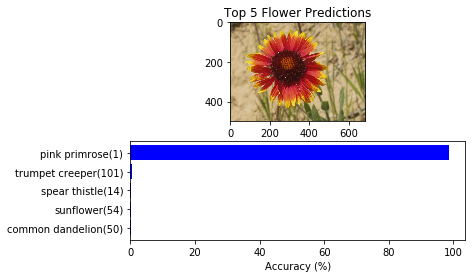

In [21]:
# Get the predictions and classes
probs, classes = predict('flowers/train/1/image_06734.jpg','check.pth')

names = [cat_to_name.get(key) for key in classes]
print("Class name:")
print(names)

print("Class number:")
print(classes)
print("Probability (%):")
for idx, item in enumerate(probs):
    probs[idx] = round(item*100, 2)
print(probs)

# Map the classes to their corresponding flower names
plant_classes = [cat_to_name[str(cls)] + "({})".format(str(cls)) for cls in classes]

# Open the image file
im = Image.open('flowers/train/100/image_07894.jpg')

# Create a figure with 2 subplots
fig, ax = plt.subplots(2,1)

# Show the image on the first subplot
ax[0].imshow(im);

# Set the y positions for the bar chart
y_positions = np.arange(len(plant_classes))

# Create a bar chart of the predictions on the second subplot
ax[1].barh(y_positions,probs,color='blue')

# Set the y-tick labels to be the flower names
ax[1].set_yticks(y_positions)
ax[1].set_yticklabels(plant_classes)

# Invert the y-axis so the labels are in descending order
ax[1].invert_yaxis()

# Set the x-label for the bar chart
ax[1].set_xlabel('Accuracy (%)')

# Set the title for the whole figure
ax[0].set_title('Top 5 Flower Predictions')

<font color='red'>**Reminder for Workspace users:** If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again. 
    
We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.</font>

In [ ]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace

In [ ]:
ls -lh